# Conexão com o data lake s3

In [1]:
import s3fs
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:

bucket_name = 'fiap-tch3-mlet'
prefix = 'dados_financeiros/'

In [4]:
# Inicializa o sistema de arquivos S3
fs = s3fs.S3FileSystem()

# Lista todos os arquivos Parquet dentro do prefixo
arquivos = fs.glob(f'{bucket_name}/{prefix}**/dados.parquet')
print(f"Arquivos encontrados: {len(arquivos)}")

Arquivos encontrados: 133


In [6]:
# Agora, carrega todos os arquivos e junta
dfs = []

for arquivo in arquivos:
    print(f"Lendo {arquivo}...")

    # Abrir o arquivo
    with fs.open(arquivo) as f:
        table = pq.read_table(f)
        df_temp = table.to_pandas()  # Sem types_mapper aqui

    # Agora, converte a coluna 'ticker' para string
    if 'ticker' in df_temp.columns:
        df_temp['ticker'] = df_temp['ticker'].astype(str)

    dfs.append(df_temp)

Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2007/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2008/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2009/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2010/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2011/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2012/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2013/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2014/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2015/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2016/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2017/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2018/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2019/dad

In [7]:
df_total = pd.concat(dfs, ignore_index=True)
print(df_total.head())

        Date     Close      High       Low      Open      Volume ticker
0 2007-01-03  2.521843  2.605503  2.464665  2.596776  1238319600   AAPL
1 2007-01-04  2.577819  2.586546  2.522446  2.529368   847260400   AAPL
2 2007-01-05  2.559461  2.594068  2.539900  2.581128   834741600   AAPL
3 2007-01-08  2.572100  2.604000  2.566382  2.586846   797106800   AAPL
4 2007-01-09  2.785763  2.798101  2.562469  2.601591  3349298400   AAPL


## Análise Exploratória

In [8]:
#Checando os tipos de dados
print(df_total.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32305 entries, 0 to 32304
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    32305 non-null  datetime64[ns]
 1   Close   32305 non-null  float64       
 2   High    32305 non-null  float64       
 3   Low     32305 non-null  float64       
 4   Open    32305 non-null  float64       
 5   Volume  32305 non-null  int64         
 6   ticker  32305 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.7+ MB
None


In [9]:
#Estatísticas descritivas
print(df_total.describe())

                                Date         Close          High  \
count                          32305  32305.000000  32305.000000   
mean   2016-03-02 06:06:19.111592704    449.337706    452.316474   
min              2007-01-03 00:00:00      1.751500      1.853500   
25%              2011-08-01 00:00:00     21.811575     21.997785   
50%              2016-03-03 00:00:00     88.528542     89.428574   
75%              2020-10-01 00:00:00    199.479996    201.949997   
max              2025-05-06 00:00:00   6144.149902   6147.430176   
std                              NaN   1000.558505   1005.817496   

                Low          Open        Volume  
count  32305.000000  32305.000000  3.230500e+04  
mean     446.002167    449.237926  6.637197e+08  
min        1.734000      1.764500  1.584340e+05  
25%       21.615793     21.784778  1.578200e+07  
50%       87.487813     88.528519  5.013310e+07  
75%      196.768155    199.490005  1.677012e+08  
max     6111.149902   6134.500000  1.

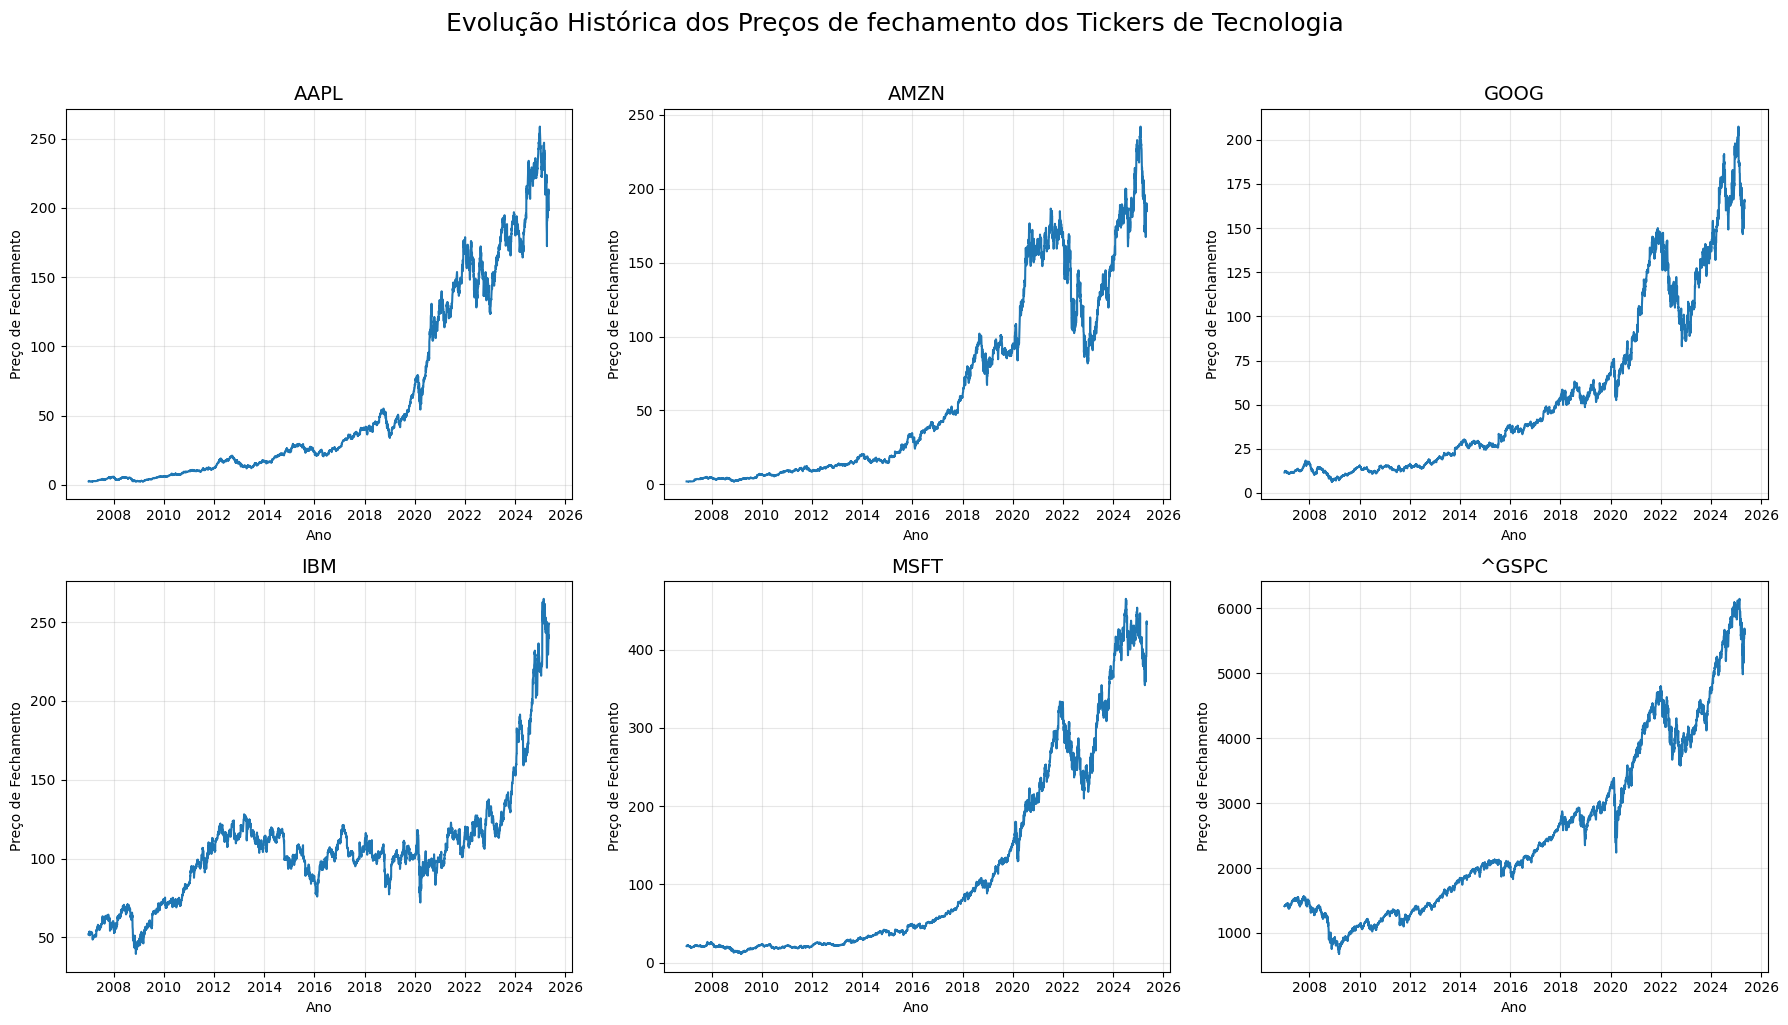

In [17]:
#Análise por ticker
tickers = df_total['ticker'].unique()
tickers = [ticker for ticker in tickers if ticker != 'NFLX']
tickers_painel = tickers[:6]

# Criando um painel de gráficos para os tickers de interesse
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 linhas, 3 colunas
axs = axs.flatten()



for i, ticker in enumerate(tickers_painel):
    df_ticker = df_total[df_total['ticker'] == ticker]
    
    axs[i].plot(df_ticker['Date'], df_ticker['Close'], label=f'{ticker}')
    
    axs[i].set_title(f'{ticker}', fontsize=14)
    axs[i].set_xlabel('Ano')
    axs[i].set_ylabel('Preço de Fechamento')
    
    # Formatar eixo de data
    axs[i].xaxis.set_major_locator(mdates.YearLocator(base=2))  # marca de 2 em 2 anos
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    axs[i].grid(alpha=0.3)

    fig.suptitle('Evolução Histórica dos Preços de fechamento dos Tickers de Tecnologia', fontsize=18, y=1.02)

plt.tight_layout()
plt.show()

Engenharia de Features para séries temporais financeiras

Carregamento e filtro dos dados
Selecionar apenas um ticker para análise (ex: AAPL) e garantir que os dados estejam ordenados corretamente no tempo.

In [10]:
df_total = df_total.sort_values(['ticker', 'Date']).reset_index(drop=True)

In [11]:
# Função para gerar features por ticker
def gerar_features(df):
    df = df.copy()
    df['ret_1d'] = df['Close'].pct_change(1)
    df['ret_5d'] = df['Close'].pct_change(5)
    df['ret_10d'] = df['Close'].pct_change(10)
    
    df['sma_5'] = df['Close'].rolling(5).mean()
    df['sma_10'] = df['Close'].rolling(10).mean()
    df['sma_20'] = df['Close'].rolling(20).mean()
    
    df['std_5'] = df['Close'].rolling(5).std()
    df['std_10'] = df['Close'].rolling(10).std()
    
    # RSI 14
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # MACD line
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26

    df['log_volume'] = np.log(df['Volume'])
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month

    # Target binário: retorno de 5 dias à frente
    df['ret_fut_5d'] = df['Close'].pct_change(5).shift(-5)
    df['target'] = (df['ret_fut_5d'] > 0).astype(int)

    return df

# Aplica para cada ticker
df_features = df_total.groupby('ticker').apply(gerar_features).reset_index(drop=True)

# Remove linhas com NaN após cálculo de indicadores
df_features = df_features.dropna().reset_index(drop=True)

C:\Users\mahno\AppData\Local\Temp\ipykernel_3708\3749826122.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df_total.groupby('ticker').apply(gerar_features).reset_index(drop=True)


In [12]:
df_features.head()

,Date,Close,High,Low,Open,Volume,ticker,ret_1d,ret_5d,ret_10d,...,sma_20,std_5,std_10,rsi_14,macd,log_volume,dayofweek,month,ret_fut_5d,target
0,2007-01-31,2.579924,2.588050,2.538395,2.553743,856069200,AAPL,0.002104,-0.011188,-0.097104,...,2.674764,0.010221,0.038142,21.410561,-0.003282,20.567862,2,1,0.004899,1
1,2007-02-01,2.550132,2.596174,2.550132,2.594971,664342000,AAPL,-0.011548,-0.017507,-0.048613,...,2.676179,0.013757,0.031087,21.641183,-0.008817,20.314308,3,2,0.016993,1
2,2007-02-02,2.550433,2.565479,2.518835,2.531474,621530000,AAPL,0.000118,-0.007379,-0.042373,...,2.674809,0.016919,0.021208,23.077146,-0.013030,20.247695,4,2,-0.017463,0
3,2007-02-05,2.526056,2.564877,2.526056,2.536890,578852400,AAPL,-0.009558,-0.023272,-0.032838,...,2.673139,0.021661,0.024303,10.504453,-0.018126,20.176558,0,2,0.011199,1
4,2007-02-06,2.532376,2.542006,2.493555,2.541404,864393600,AAPL,0.002502,-0.016365,-0.018087,...,2.671153,0.020947,0.027126,13.315508,-0.021409,20.577539,1,2,0.006536,1


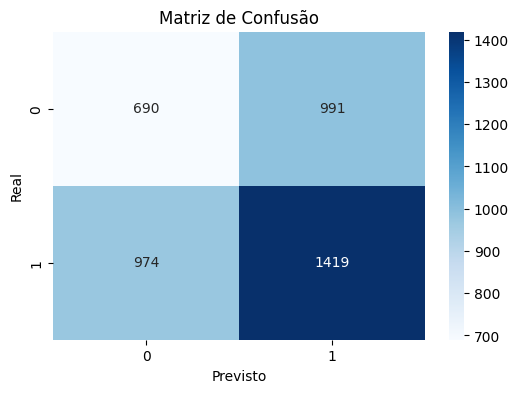

(np.float64(0.5126070412090787),
 {'0': {'precision': 0.41466346153846156,
   'recall': 0.41046995835812017,
   'f1-score': 0.4125560538116592,
   'support': 1681.0},
  '1': {'precision': 0.5887966804979253,
   'recall': 0.5929795236105307,
   'f1-score': 0.5908806995627732,
   'support': 2393.0},
  'accuracy': 0.5176730486008837,
  'macro avg': {'precision': 0.5017300710181934,
   'recall': 0.5017247409843255,
   'f1-score': 0.5017183766872162,
   'support': 4074.0},
  'weighted avg': {'precision': 0.5169464249577047,
   'recall': 0.5176730486008837,
   'f1-score': 0.5173009917798516,
   'support': 4074.0}})

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define features e target
features = [
    'ret_1d', 'ret_5d', 'ret_10d', 'sma_5', 'sma_10', 'sma_20',
    'std_5', 'std_10', 'rsi_14', 'macd', 'log_volume', 'dayofweek', 'month'
]
target = 'target'

# Split treino/teste por tempo (ex: até final de 2022 treino, 2023 teste)
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_train = df_features[df_features['Date'] < '2023-01-01']
df_test = df_features[df_features['Date'] >= '2023-01-01']

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# Treina modelo
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)

# Previsões e avaliação
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]



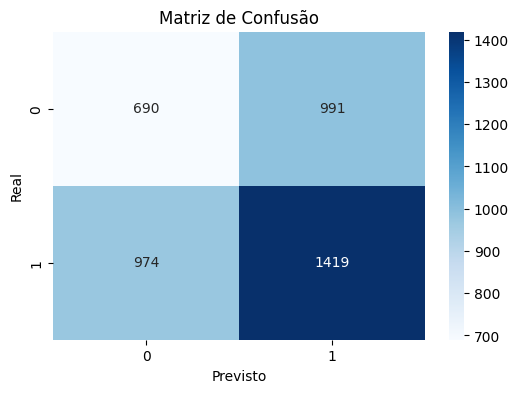

(np.float64(0.5126070412090787),
 {'0': {'precision': 0.41466346153846156,
   'recall': 0.41046995835812017,
   'f1-score': 0.4125560538116592,
   'support': 1681.0},
  '1': {'precision': 0.5887966804979253,
   'recall': 0.5929795236105307,
   'f1-score': 0.5908806995627732,
   'support': 2393.0},
  'accuracy': 0.5176730486008837,
  'macro avg': {'precision': 0.5017300710181934,
   'recall': 0.5017247409843255,
   'f1-score': 0.5017183766872162,
   'support': 4074.0},
  'weighted avg': {'precision': 0.5169464249577047,
   'recall': 0.5176730486008837,
   'f1-score': 0.5173009917798516,
   'support': 4074.0}})

In [15]:
# Métricas
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, output_dict=True)

# Gráficos
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

roc_auc, report


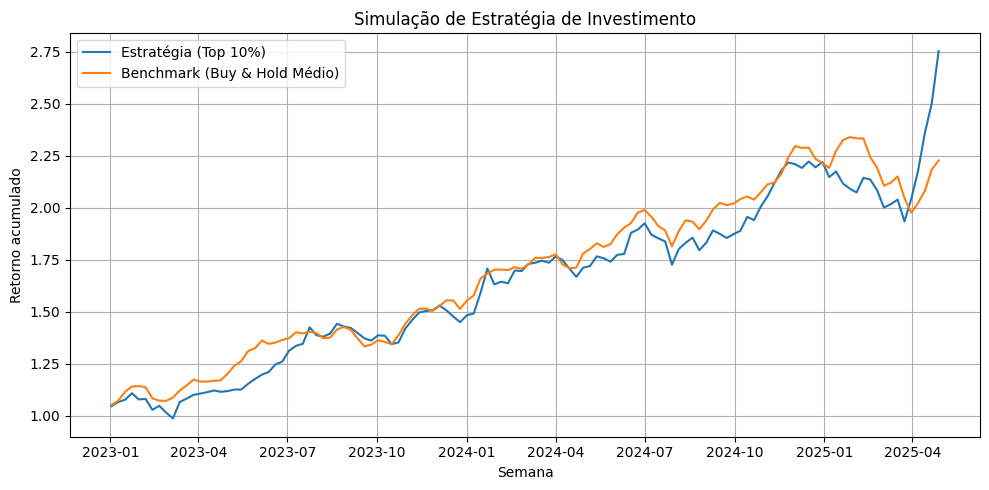

(np.float64(2.7532662886911), np.float64(2.227689576823457))

In [16]:
# Vamos simular uma estratégia simples:
# - A cada semana, investe nos tickers com maior probabilidade prevista de retorno positivo (top 10%)
# - O retorno da estratégia será a média real desses ativos

df_test = df_test.copy()
df_test['proba_1'] = y_proba
df_test['real_return'] = df_test['ret_fut_5d']  # retorno real de 5 dias

# Agrupa por semana
df_test['week'] = df_test['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Em cada semana, seleciona os top 10% ativos pela maior probabilidade prevista
weekly_returns = []
for week, group in df_test.groupby('week'):
    top_preds = group.sort_values('proba_1', ascending=False).head(max(1, int(0.1 * len(group))))
    mean_return = top_preds['real_return'].mean()
    weekly_returns.append({'week': week, 'mean_return': mean_return})

# Converte em DataFrame
df_strategy = pd.DataFrame(weekly_returns)
df_strategy['cumulative_return'] = (1 + df_strategy['mean_return']).cumprod()

# Compara com estratégia "Buy and Hold" do benchmark médio
benchmark = df_test.groupby('week')['real_return'].mean().reset_index()
benchmark['cumulative_return'] = (1 + benchmark['real_return']).cumprod()

# Plotando comparação
plt.figure(figsize=(10, 5))
plt.plot(df_strategy['week'], df_strategy['cumulative_return'], label='Estratégia (Top 10%)')
plt.plot(benchmark['week'], benchmark['cumulative_return'], label='Benchmark (Buy & Hold Médio)')
plt.title('Simulação de Estratégia de Investimento')
plt.xlabel('Semana')
plt.ylabel('Retorno acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Retorno final da estratégia vs benchmark
final_strategy_return = df_strategy['cumulative_return'].iloc[-1]
final_benchmark_return = benchmark['cumulative_return'].iloc[-1]

final_strategy_return, final_benchmark_return


In [17]:
# Cálculo de métricas financeiras da estratégia
def calcular_metricas(retornos_semanais):
    retornos = retornos_semanais['mean_return']
    
    # Sharpe Ratio (semana -> ano = sqrt(52))
    sharpe = (retornos.mean() / retornos.std()) * np.sqrt(52)
    
    # Volatilidade anualizada
    volatilidade = retornos.std() * np.sqrt(52)
    
    # Max Drawdown
    cumulativo = (1 + retornos).cumprod()
    max_cumulativo = cumulativo.cummax()
    drawdown = (cumulativo - max_cumulativo) / max_cumulativo
    max_drawdown = drawdown.min()
    
    return {
        'Sharpe Ratio': sharpe,
        'Volatilidade anualizada': volatilidade,
        'Max Drawdown (%)': max_drawdown * 100
    }

metricas_estrategia = calcular_metricas(df_strategy)
metricas_benchmark = calcular_metricas(benchmark)

metricas_estrategia, metricas_benchmark


KeyError: 'mean_return'